In [2]:
pip install numpy pandas matplotlib scikit-learn scipy tqdm librosa


Note: you may need to restart the kernel to use updated packages.


🔍 Extracting features from MFCC files...


100%|██████████| 116/116 [01:06<00:00,  1.75it/s]


✅ Feature matrix shape: (116, 60)


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\akhil\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


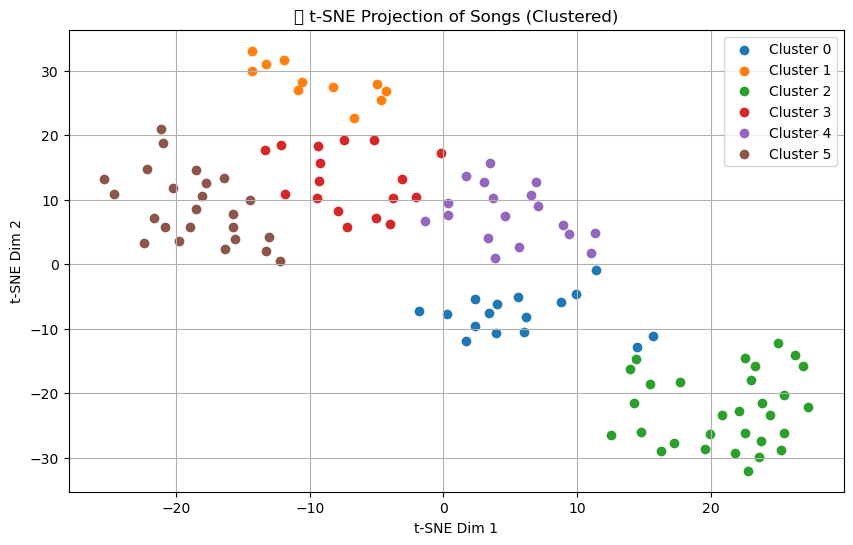

📁 Saved cluster info to: clustered_mfcc_songs.csv


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.stats import skew
from tqdm import tqdm

# STEP 1: Set the folder path where your MFCC CSV files are
extract_path = "mfcc_data"  # This is the folder that has all your 01-MFCC.csv to 115-MFCC.csv

# STEP 2: Load each MFCC file and compute statistical features
def extract_features(file_path):
    df = pd.read_csv(file_path, header=None)
    features = []
    for row in df.values:
        features.append(np.mean(row))
        features.append(np.std(row))
        features.append(skew(row))
    return features

features_list = []
filenames = []

print("🔍 Extracting features from MFCC files...")
for file in tqdm(sorted(os.listdir(extract_path))):
    if file.endswith(".csv"):
        path = os.path.join(extract_path, file)
        features = extract_features(path)
        features_list.append(features)
        filenames.append(file)

# Create final dataset
X = np.array(features_list)
print("✅ Feature matrix shape:", X.shape)

# STEP 3: Reduce dimensionality using PCA → t-SNE for visualization
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(X_pca)

# STEP 4: Apply KMeans clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_tsne)

# STEP 5: Plot the clusters using t-SNE
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster = X_tsne[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f"Cluster {i}")
plt.title("🎵 t-SNE Projection of Songs (Clustered)")
plt.legend()
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()

# STEP 6: Save cluster results to CSV
results_df = pd.DataFrame({
    "Filename": filenames,
    "Cluster": labels
})
results_df.to_csv("clustered_mfcc_songs.csv", index=False)
print("📁 Saved cluster info to: clustered_mfcc_songs.csv")


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load cluster results
cluster_df = pd.read_csv("clustered_mfcc_songs.csv")

# 📝 Manually assign labels to clusters
# Replace with what you found (e.g., Asha = cluster 1, Kishore = cluster 2, etc.)
cluster_to_gender = {
    0: 'Female',
    1: 'Male',
    2: 'Male',
    3: 'Female',
    4: 'Duet',
    5: 'Female'
}

cluster_df['Gender_Label'] = cluster_df['Cluster'].map(cluster_to_gender)

# Filter rows where we have known gender labels
labeled_df = cluster_df[cluster_df['Gender_Label'].notnull()]
X_gender = X[labeled_df.index]
y_gender = labeled_df['Gender_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_gender, y_gender, test_size=0.3, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("\n🎤 Gender Classifier Report:")
print(classification_report(y_test, y_pred))

# Save results for entire dataset
cluster_df['Predicted_Gender'] = clf.predict(X)
cluster_df.to_csv("gender_classification_results.csv", index=False)
print("✅ Saved predictions to gender_classification_results.csv")



🎤 Gender Classifier Report:
              precision    recall  f1-score   support

        Duet       1.00      0.33      0.50         3
      Female       0.94      0.94      0.94        16
        Male       0.89      1.00      0.94        16

    accuracy                           0.91        35
   macro avg       0.94      0.76      0.79        35
weighted avg       0.92      0.91      0.90        35

✅ Saved predictions to gender_classification_results.csv


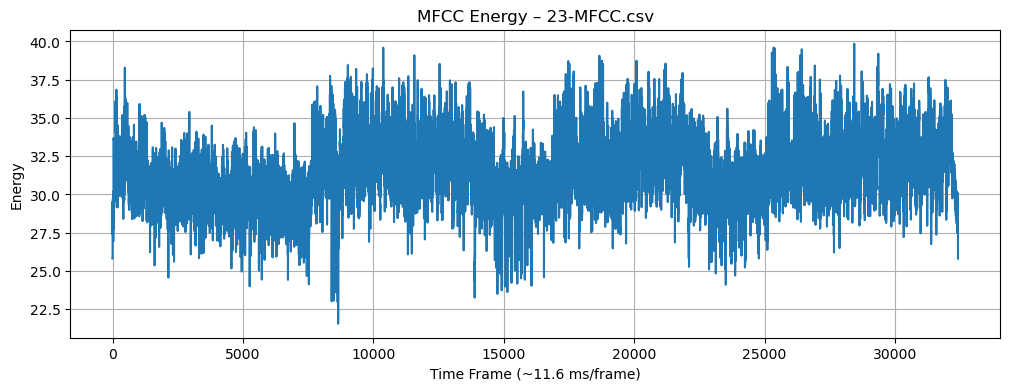


🕒 Vocal Segments in 23-MFCC.csv (top 3):
🔹 Segment: 0.51s to 0.55s
🔹 Segment: 0.89s to 0.89s
🔹 Segment: 1.14s to 1.87s


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Choose a file to analyze
target_file = "23-MFCC.csv"  # Change this to the filename you want to analyze
path = os.path.join("mfcc_data", target_file)

# Load MFCC
mfcc = pd.read_csv(path, header=None).values

# Compute energy (mean of absolute MFCC values at each timestep)
energy = np.mean(np.abs(mfcc), axis=0)

# Plot the energy
plt.figure(figsize=(12, 4))
plt.plot(energy)
plt.title(f"MFCC Energy – {target_file}")
plt.xlabel("Time Frame (~11.6 ms/frame)")
plt.ylabel("Energy")
plt.grid(True)
plt.show()

# Detect vocal regions using threshold
threshold = np.percentile(energy, 75)
above = np.where(energy > threshold)[0]

# Group into segments
segments = []
if len(above) > 0:
    start = above[0]
    for i in range(1, len(above)):
        if above[i] - above[i - 1] > 10:  # Gap between segments
            end = above[i - 1]
            segments.append((start, end))
            start = above[i]
    segments.append((start, above[-1]))

# Convert frames to seconds (1 frame ≈ 0.0116 sec)
time_per_frame = 512 / 44100
print(f"\n🕒 Vocal Segments in {target_file} (top 3):")
for (s, e) in segments[:3]:
    start_sec = round(s * time_per_frame, 2)
    end_sec = round(e * time_per_frame, 2)
    print(f"🔹 Segment: {start_sec}s to {end_sec}s")


In [11]:
cluster_to_label = {
    0: "National Anthem",
    1: "Asha Bhosale",
    2: "Kishore Kumar",
    3: "Michael Jackson",
    4: "Marathi Bhav Geet",
    5: "Marathi Lavni"
}


In [13]:
import pandas as pd

# Load your clustered file
df = pd.read_csv("clustered_mfcc_songs.csv")

# Your cluster mapping (edit this based on what you identified)
cluster_to_label = {
    0: "National Anthem",
    1: "Asha Bhosale",
    2: "Kishore Kumar",
    3: "Michael Jackson",
    4: "Bhav Geet",
    5: "Lavni"
}

df["Category"] = df["Cluster"].map(cluster_to_label)

# 1. Table of National Anthem files
anthem_df = df[df["Category"] == "National Anthem"].copy()
anthem_df = anthem_df.head(5)
print("🎵 National Anthem Files:\n", anthem_df[["Filename", "Category"]])

# 2. Asha Bhosale songs
asha_df = df[df["Category"] == "Asha Bhosale"].copy().head(5)
print("\n🎤 Asha Bhosale Songs:\n", asha_df[["Filename", "Category"]])

# 3. Kishore Kumar songs
kishore_df = df[df["Category"] == "Kishore Kumar"].copy().head(5)
print("\n🎤 Kishore Kumar Songs:\n", kishore_df[["Filename", "Category"]])

# 4. Michael Jackson songs
mj_df = df[df["Category"] == "Michael Jackson"].copy().head(5)
print("\n🎤 Michael Jackson Songs:\n", mj_df[["Filename", "Category"]])

# 5. Optional: Full cluster summary table
summary = df.groupby("Category").agg({"Filename": "count"}).rename(columns={"Filename": "Num Files"})
print("\n📊 Cluster Summary Table:\n", summary)

# Save all for presentation
anthem_df.to_csv("table_national_anthem.csv", index=False)
asha_df.to_csv("table_asha.csv", index=False)
kishore_df.to_csv("table_kishore.csv", index=False)
mj_df.to_csv("table_mj.csv", index=False)
summary.to_csv("table_cluster_summary.csv")
print("\n✅ All summary tables saved.")


🎵 National Anthem Files:
         Filename         Category
19  109-MFCC.csv  National Anthem
21  110-MFCC.csv  National Anthem
26  115-MFCC.csv  National Anthem
35   19-MFCC.csv  National Anthem
41   25-MFCC.csv  National Anthem

🎤 Asha Bhosale Songs:
         Filename      Category
2    03-MFCC.csv  Asha Bhosale
7    08-MFCC.csv  Asha Bhosale
13  103-MFCC.csv  Asha Bhosale
25  114-MFCC.csv  Asha Bhosale
36   20-MFCC.csv  Asha Bhosale

🎤 Kishore Kumar Songs:
         Filename       Category
4    05-MFCC.csv  Kishore Kumar
6    07-MFCC.csv  Kishore Kumar
8    09-MFCC.csv  Kishore Kumar
10  100-MFCC.csv  Kishore Kumar
11  101-MFCC.csv  Kishore Kumar

🎤 Michael Jackson Songs:
         Filename         Category
5    06-MFCC.csv  Michael Jackson
14  104-MFCC.csv  Michael Jackson
18  108-MFCC.csv  Michael Jackson
31   15-MFCC.csv  Michael Jackson
38   22-MFCC.csv  Michael Jackson

📊 Cluster Summary Table:
                  Num Files
Category                  
Asha Bhosale            11
Bhav